<a href="https://colab.research.google.com/github/fboldt/aulasann/blob/plan/aula04_planejamento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [125]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import numpy as np

iris = load_iris()
X, y = iris.data, iris.target
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.5)
Xtr.shape, Xte.shape, ytr.shape, yte.shape

((75, 4), (75, 4), (75,), (75,))

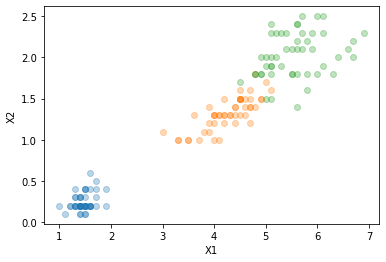

In [126]:
import matplotlib.pyplot as plt

def plotaDatasetBidimensional(X, y):
    """
    Plota um dataset bidimensional.
    """
    plt.xlabel('X1')
    plt.ylabel('X2')
    for k in set(y):
        plt.plot(X[:,0][y==k],X[:,1][y==k], "o", alpha=0.3)

plotaDatasetBidimensional(X[:,2:], y)

In [127]:
from abc import ABC, abstractstaticmethod

class Custo(ABC):
    @abstractstaticmethod
    def custo(y, ypred):
        pass
    @abstractstaticmethod
    def gradiente(y, ypred, X):
        pass

class WidrowHoff(Custo):
    @staticmethod
    def custo(y, ypred):
        return np.sum((1 - (y * ypred))**2)
    @staticmethod
    def gradiente(y, ypred, X):
        return X.T @ (y - ypred)

class SmoothedSurrogate(Custo):
    @staticmethod
    def custo(y, ypred):
        return np.sum(np.maximum(np.zeros(y.shape), - y * ypred))
    @staticmethod
    def gradiente(y, ypred, X):
        return X.T @ (y - sign(ypred))

class HingeLoss(Custo):
    @staticmethod
    def custo(y, ypred):
        return np.sum(np.maximum(np.zeros(y.shape), 1 - y * ypred))
    @staticmethod
    def gradiente(y, ypred, X):
        errosmarginais = (y * ypred) < 1
        ymarginais = np.copy(y)
        ymarginais[~errosmarginais] = 0
        g = X.T @ ymarginais
        return g

from scipy.special import expit

class LogLikelihood(Custo):
    @staticmethod
    def custo(y, ypred):
        return np.sum(np.log(1 + np.exp(- y * ypred)))
    @staticmethod
    def gradiente(y, ypred, X):
        return X.T @ (y - (expit(ypred)*2-1))

In [128]:
from abc import ABC, abstractmethod

class TrainingAlgorithm(ABC):
  @abstractmethod
  def getW(self, X, y, activation):
    pass

class PseudoInversa(TrainingAlgorithm):
  def __init__(self, regularization=0):
    self.regularization = regularization
  def getW(self, X, y):
    return np.linalg.inv(X.T @ X + np.eye(X.shape[1])*self.regularization) @ X.T @ y


class DescidaGradiente(TrainingAlgorithm):
  def __init__(self, max_iter=100, learning_rate=0.05, 
               regularization=0, cost=WidrowHoff()):
    self.max_iter = max_iter
    self.learning_rate = learning_rate
    self.regularization = regularization
    self.cost = cost

  def getW(self, X, y):
    w = np.random.uniform(-1, 1, size=(X.shape[1], y.shape[1]))
    for _ in range(self.max_iter):
      ypred = X @ w
      if self.cost.custo(y, ypred) == 0:
        break
      w *= 1 - self.regularization * self.learning_rate
      w += self.cost.gradiente(y, ypred, X) * self.learning_rate
    return w

In [129]:
def sigmoid(x):
  return 1/(1 + np.exp(-x))

def accuracy(yactual, ypred):
  return sum(yactual == ypred)/len(yactual)

In [130]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import label_binarize

def include_bias(X):
  bias = np.ones((X.shape[0], 1))
  Xb = np.concatenate((bias, X), axis=1)
  return Xb

class Perceptron(BaseEstimator, ClassifierMixin):
  def __init__(self, training_algorithm=DescidaGradiente()):
    self.w = None
    self.training_algorithm = training_algorithm

  def encode_labels(self, y):
    self.labels = list(set(y))
    return label_binarize(y, classes=self.labels)*2-1

  def fit(self, X, y):
    Xb = include_bias(X)
    yhot = self.encode_labels(y)
    self.w = self.training_algorithm.getW(Xb, yhot)

  def __pre_activation(self, X):
    Xb = include_bias(X)
    return Xb @ self.w

  def predict_proba(self, X):
    return sigmoid(self.__pre_activation(X))

  def predict(self, X):
    a = self.predict_proba(X)
    if self.w.shape[1] == 1:
      idx = np.array(a > 0.5, dtype=int).reshape((-1,))
    else:
      idx = np.argmax(a, axis=1)
    ypred = np.array([self.labels[i] for i in idx])
    return ypred

perceptron = Perceptron(training_algorithm=DescidaGradiente(cost=LogLikelihood()))
perceptron.fit(Xtr, ytr)
print(accuracy(ytr, perceptron.predict(Xtr)))
print(perceptron.w)

0.68
[[  4.21326587   5.40637708 -18.97646785]
 [  7.28125929   6.82528057 -27.94575913]
 [ 18.20724984 -24.64459833 -41.8217135 ]
 [-26.53679625  28.66515754  69.80187507]
 [-12.06699325  -7.37393938  50.23719194]]


In [131]:
custos = [WidrowHoff(), SmoothedSurrogate(), HingeLoss(), LogLikelihood()]

for custo in custos:
    perceptron = Perceptron(training_algorithm=DescidaGradiente(max_iter=10000,
        learning_rate=0.0001, regularization=0, cost=custo))
    perceptron.fit(Xtr, ytr)
    print(accuracy(ytr, perceptron.predict(Xtr)), accuracy(yte, perceptron.predict(Xte)))
    print(perceptron.w)

0.84 0.8266666666666667
[[ 0.1392618   1.26260872 -0.74512091]
 [ 0.06353273 -0.14526184 -0.05995494]
 [ 0.35929257 -0.56577853 -0.04971182]
 [-0.54374854  0.64250614 -0.17003732]
 [ 0.08143481 -1.20237589  1.32728253]]
0.92 0.8933333333333333
[[ 0.33619199  0.70189724 -0.42126403]
 [-0.19084573 -0.10166493  0.05615874]
 [ 0.17182089 -0.15041694 -0.20858686]
 [ 0.13480196  0.21378997 -0.06382073]
 [-0.28623351 -0.34406855  0.65153894]]
0.9466666666666667 0.9333333333333333
[[ 0.37546928 -0.18977656 -1.69253424]
 [ 0.44024006 -0.06643942 -1.44281975]
 [ 0.19946649 -0.261458   -1.85042602]
 [-1.04555232  0.28981146  2.56125239]
 [-0.89342349 -0.5496991   2.19722136]]
0.9866666666666667 0.9466666666666667
[[-0.04358109  1.38485821 -0.81826612]
 [ 0.12640175 -0.06608952 -2.04420334]
 [ 2.70960281 -1.30359783 -3.0768907 ]
 [-2.85810036  1.27027004  3.34049124]
 [-1.40539317 -2.25201583  3.86501771]]
